## 0. Install necesarry packages

In [ ]:
#!pip install keras
#!pip install tensorflow

## 1. Import necessary libraries


In [2]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np



## 2. Preprocessing data
Normalization & Augumentation of Image Data

In [3]:
# Transformations for training (augmentation + normalization)
transform_train = transforms.Compose([
    # Geometric transformations
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    # Convert to tensor
    transforms.ToTensor(),
    # Color transformations
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalization
])

# Transformations for testing (only normalization)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalization
])

## 3. Data Preparation and Exploration


Download the CIFAR-10 dataset from torchvision

In [16]:
# Download CIFAR-10 for training
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train # Apply transformations
)

# Download CIFAR-10 for testing
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

Files already downloaded and verified
Files already downloaded and verified


Create Dataloaders fo train, test & validation

In [17]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the data shape
print(f"Numărul de imagini de antrenament: {len(train_dataset)}")
print(f"Numărul de imagini de testare: {len(test_dataset)}")


Numărul de imagini de antrenament: 50000
Numărul de imagini de testare: 10000


Visualization of the dataset

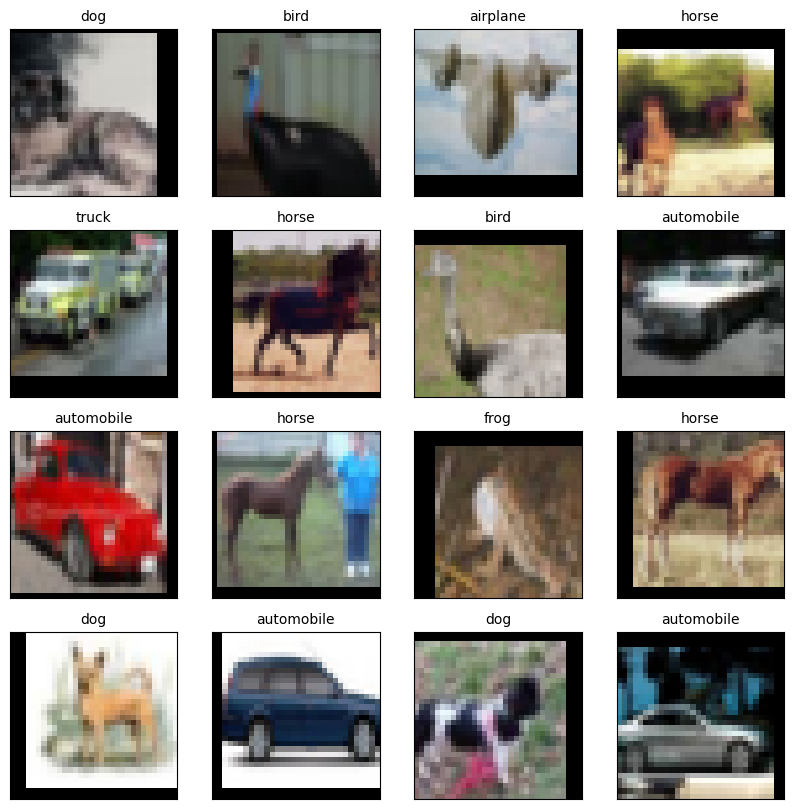

In [ ]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Retrieve a batch of images and labels from DataLoader
dataiter = iter(train_loader) # Create the iterator
images, labels = next(dataiter)

def unnormalize(img):
    img = img * 0.5 + 0.5  # Reverse normalization (mean=0.5, std=0.5)
    return np.clip(img, 0, 1)  # ~Math.Clamp din C#

# Set up the figure dimensions for the plot.
plt.figure(figsize=(10,10))

# Display the first 16 images in the batch
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    # Convertește imaginea din tensor la formatul (H, W, C) și denormalizează
    img = unnormalize(images[i].permute(1, 2, 0).numpy())  # rearranges to (H, W, C) - Height, Width, Channels
    plt.imshow(img)
    plt.title(class_names[labels[i].item()], fontsize=10)

plt.show()


## 4. Define the model


In [ ]:
# Configurations
batch_size = 64
num_classes = 10
num_epochs = 30
learning_rate = 0.001


In [ ]:
# Upload MobileNet pretrained
mobilenet = models.mobilenet_v2(pretrained=True)

# Adjust the final classification layer to make it suitable for classifying CIFAR-10
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes) # nr last output layer


In [ ]:
# Send to the available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mobilenet = mobilenet.to(device)

In [ ]:
# Cost function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=learning_rate, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True) # loss minimsation


## 5. Training the CNN Model

In [ ]:
import matplotlib.pyplot as plt

# Lists for loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train
    mobilenet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Evaluate on validation set
    mobilenet.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100 * correct / total)

    scheduler.step(val_loss)


    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")




Epoch [1/30], Train Loss: 1.1100, Train Accuracy: 61.77%, Val Loss: 0.7873, Val Accuracy: 73.32%

Epoch [2/30], Train Loss: 0.8340, Train Accuracy: 72.09%, Val Loss: 0.7364, Val Accuracy: 75.54%

Epoch [3/30], Train Loss: 0.7672, Train Accuracy: 74.25%, Val Loss: 0.6899, Val Accuracy: 77.26%

Epoch [4/30], Train Loss: 0.7374, Train Accuracy: 75.60%, Val Loss: 0.6759, Val Accuracy: 77.52%

Epoch [5/30], Train Loss: 0.7111, Train Accuracy: 76.41%, Val Loss: 0.6885, Val Accuracy: 76.48%

Epoch [6/30], Train Loss: 0.6917, Train Accuracy: 76.83%, Val Loss: 0.6380, Val Accuracy: 78.64%

Epoch [7/30], Train Loss: 0.6636, Train Accuracy: 77.72%, Val Loss: 0.6225, Val Accuracy: 79.10%

Epoch [8/30], Train Loss: 0.6395, Train Accuracy: 78.46%, Val Loss: 0.6208, Val Accuracy: 79.08%

Epoch [9/30], Train Loss: 0.6340, Train Accuracy: 78.71%, Val Loss: 0.5995, Val Accuracy: 79.32%

Epoch [10/30], Train Loss: 0.6218, Train Accuracy: 79.05%, Val Loss: 0.6202, Val Accuracy: 79.20%

Epoch [11/30], Train Loss: 0.6098, Train Accuracy: 79.55%, Val Loss: 0.5841, Val Accuracy: 79.98%

Epoch [12/30], Train Loss: 0.6045, Train Accuracy: 79.55%, Val Loss: 0.5621, Val Accuracy: 80.96%

Epoch [13/30], Train Loss: 0.5897, Train Accuracy: 80.18%, Val Loss: 0.5693, Val Accuracy: 80.50%

Epoch [14/30], Train Loss: 0.5903, Train Accuracy: 80.16%, Val Loss: 0.5969, Val Accuracy: 79.64%

Epoch [15/30], Train Loss: 0.5836, Train Accuracy: 80.36%, Val Loss: 0.6096, Val Accuracy: 79.60%

Epoch [16/30], Train Loss: 0.5735, Train Accuracy: 80.53%, Val Loss: 0.5535, Val Accuracy: 81.76%

Epoch [17/30], Train Loss: 0.5747, Train Accuracy: 80.69%, Val Loss: 0.5418, Val Accuracy: 81.22%

Epoch [18/30], Train Loss: 0.5714, Train Accuracy: 80.71%, Val Loss: 0.5624, Val Accuracy: 80.40%

Epoch [19/30], Train Loss: 0.5620, Train Accuracy: 81.03%, Val Loss: 0.5849, Val Accuracy: 79.98%

Epoch [20/30], Train Loss: 0.5632, Train Accuracy: 80.95%, Val Loss: 0.5667, Val Accuracy: 80.42%

Epoch [21/30], Train Loss: 0.5604, Train Accuracy: 81.17%, Val Loss: 0.5648, Val Accuracy: 80.74%

Epoch [22/30], Train Loss: 0.5514, Train Accuracy: 81.42%, Val Loss: 0.5400, Val Accuracy: 81.74%

Epoch [23/30], Train Loss: 0.5592, Train Accuracy: 81.13%, Val Loss: 0.5457, Val Accuracy: 81.16%

Epoch [24/30], Train Loss: 0.5511, Train Accuracy: 81.49%, Val Loss: 0.5465, Val Accuracy: 81.42%

Epoch [25/30], Train Loss: 0.5451, Train Accuracy: 81.49%, Val Loss: 0.5845, Val Accuracy: 80.52%

Epoch [26/30], Train Loss: 0.5475, Train Accuracy: 81.37%, Val Loss: 0.5439, Val Accuracy: 81.96%

Epoch [27/30], Train Loss: 0.5465, Train Accuracy: 81.52%, Val Loss: 0.5798, Val Accuracy: 80.58%

Epoch [28/30], Train Loss: 0.5433, Train Accuracy: 81.57%, Val Loss: 0.5507, Val Accuracy: 80.98%

Epoch [29/30], Train Loss: 0.4326, Train Accuracy: 85.31%, Val Loss: 0.4474, Val Accuracy: 85.00%

Epoch [30/30], Train Loss: 0.3925, Train Accuracy: 86.73%, Val Loss: 0.4269, Val Accuracy: 85.76%

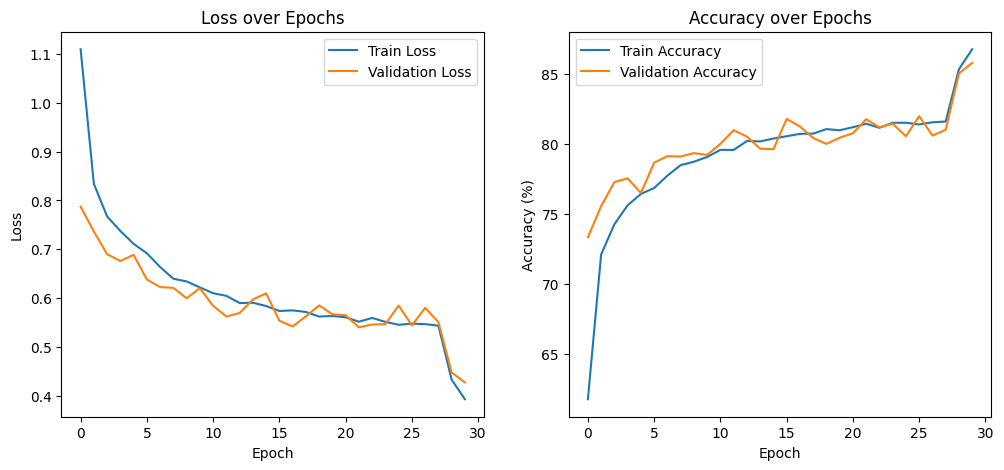

In [ ]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()


In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 49.1 MB/s eta 0:00:00


In [ ]:
import torch.onnx

# Evaluation mode
mobilenet.eval()

# Create a dummy tensor that has the same shape as the model inputs
# batch size = 1, 3 channels, 32x32 pixels
dummy_input = torch.randn(1, 3, 32, 32, device=device)
onnx_path = "mobilenetv2_cifar10.onnx"


# 4. Export the model in onnx format
torch.onnx.export(mobilenet,                # Trained model
                  dummy_input,              # Input example tensor
                  onnx_path,                # The path where the model will be saved
                  export_params=True,       # Include parameters in ONNX file
                  opset_version=11,         # Set ONNX version (11 is recommended)
                  do_constant_folding=True,  # Optimizes consistency
                  input_names=['input'],     # Input name
                  output_names=['output'],   # Output name
                  dynamic_axes={'input': {0: 'batch_size'},  # Allows dynamic batch size
                                'output': {0: 'batch_size'}})

print(f"Modelul ONNX a fost salvat la: {onnx_path}")


Modelul ONNX a fost salvat la: mobilenetv2_cifar10.onnx


In [ ]:
import onnx

# Upload ONNX model for verification
onnx_model = onnx.load(onnx_path)

# Check if the model complies with the ONNX standard
onnx.checker.check_model(onnx_model)

print(f"Modelul ONNX a fost salvat cu succes la: {onnx_path}")


Modelul ONNX a fost salvat cu succes la: mobilenetv2_cifar10.onnx
